In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings

using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")

calculate_profit (generic function with 1 method)

In [2]:
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design/20250928/")
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)

Data directory: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/


In [3]:
N = 3 # num of product
N_x = 10 # num of product feature
c_l = ones(N_x)  # X * c_l >= d_r
d_r = ones(N) * 5
rev_gap = 0.01
N_u = 5 # num of customer feature
S_train = 100 # num of training samples
S_test = 1 # num of training samples
m = 5 # num of candidates in training samples
N_nonzero = 5 # num of nonzero entries in A
lambda_list = [0.0]
gamma_list = [0.0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,1.0]

instances = 100
Random.seed!(2)

TaskLocalRNG()

#### Data Generation

In [4]:
Input_Data = Dict()
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    # ****** Data ******
    theta_true, r_params = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero);
    X_train,Y_train,Z_train = Generate_Wang_Qi_Max_True_Data(N_x, N_u, S_train, m,theta_true);
    X_test,Y_test,Z_test = Generate_Wang_Qi_Max_True_Data(N_x, N_u, S_test, m,theta_true);

    Input_Data["theta_true_ins=$ins"] = theta_true
    Input_Data["r_params_ins=$ins"] = r_params
    Input_Data["X_train_ins=$ins"] = X_train
    Input_Data["Y_train_ins=$ins"] = Y_train
    Input_Data["Z_train_ins=$ins"] = Z_train
    Input_Data["X_test_ins=$ins"] = X_test
    Input_Data["Y_test_ins=$ins"] = Y_test
    Input_Data["Z_test_ins=$ins"] = Z_test
end
save(string(data_dir,"Input_Data.jld2"),Input_Data)

#### Estimation

In [5]:
Estimate_Dict = Dict()
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    X_train = Input_Data["X_train_ins=$ins"]
    Y_train = Input_Data["Y_train_ins=$ins"]
    Z_train = Input_Data["Z_train_ins=$ins"]
    for lambda in lambda_list
        alpha0_hat, alpha_hat, beta_hat, A_hat, opt_result = estimate_parameters(X_train,Y_train,Z_train,lambda, N_x, N_u, initial_theta=randn((N_x+1)*(N_u+1)) * 0.1);
        Estimate_Dict["alpha0_ins=$(ins)_lambda=$lambda"] = alpha0_hat
        Estimate_Dict["alpha_ins=$(ins)_lambda=$lambda"] = alpha_hat
        Estimate_Dict["beta_ins=$(ins)_lambda=$lambda"] = beta_hat
        Estimate_Dict["A_ins=$(ins)_lambda=$lambda"] = A_hat
        Estimate_Dict["opt_result_ins=$(ins)_lambda=$lambda"] = opt_result
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
end
save(string(data_dir,"Estimate_Dict.jld2"),Estimate_Dict)

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=6/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=7/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_D

#### True

In [6]:
function get_input_data_ins(Input_Data,ins)
    theta_true = Input_Data["theta_true_ins=$ins"]
    r_params = Input_Data["r_params_ins=$ins"]
    X_train = Input_Data["X_train_ins=$ins"]
    Y_train = Input_Data["Y_train_ins=$ins"]
    Z_train = Input_Data["Z_train_ins=$ins"]
    X_test = Input_Data["X_test_ins=$ins"]
    Y_test = Input_Data["Y_test_ins=$ins"]
    Z_test = Input_Data["Z_test_ins=$ins"]
    r0 = r_params.r0;
    r = r_params.r;
    alp0_true = theta_true.alpha0;
    alp_true = theta_true.alpha;
    beta_true = theta_true.beta;
    A_true = theta_true.A;
    return r0,r,alp0_true,alp_true,beta_true,A_true,Z_test
end

get_input_data_ins (generic function with 1 method)

In [7]:
Result_True_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    r0,r,alp0_true,alp_true,beta_true,A_true,Z_test = get_input_data_ins(Input_Data,ins)

    obj_True_list = zeros(S_test);
    x_True_list = zeros(S_test,N,N_x);
    time_True_list = zeros(S_test);
    profit_True_list = zeros(S_test);
    for i in 1:S_test
        z_input = Z_test[i,:];
        nu0 = alp0_true + beta_true' * z_input;
        nu = alp_true .+ A_true * z_input;
        obj_True_list[i], x_True_list[i,:,:], time_True_list[i] = ETO_PLD(N,N_x,nu0, nu, r0, r,c_l,d_r,rev_gap);
        profit_True_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_True_list[i,:,:], z_input)
        # if i % 20 == 1
        #     println("True: i=$i, obj=$(round(obj_True_list[i], digits=4)), profit=$(round(profit_True_list[i], digits=4)), time=$(round(time_True_list[i],digits=4))")
        # end                         
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
    Result_True_Dict["obj_ins=$ins"] = obj_True_list
    Result_True_Dict["sol_ins=$ins"] = x_True_list
    Result_True_Dict["time_ins=$ins"] = time_True_list
    Result_True_Dict["profit_ins=$ins"] = profit_True_list
end
save(string(data_dir,"Result_True.jld2"),Result_True_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=6/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=7/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_D

#### Estimate-then-optimize

In [8]:
Result_ETO_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    r0,r,alp0_true,alp_true,beta_true,A_true,Z_test = get_input_data_ins(Input_Data,ins)

    lambda_len = length(lambda_list)
    for l_index in 1:lambda_len
        lambda = lambda_list[l_index]
        alpha0_hat = Estimate_Dict["alpha0_ins=$(ins)_lambda=$lambda"]
        alpha_hat = Estimate_Dict["alpha_ins=$(ins)_lambda=$lambda"]
        beta_hat = Estimate_Dict["beta_ins=$(ins)_lambda=$lambda"]
        A_hat = Estimate_Dict["A_ins=$(ins)_lambda=$lambda"]

        obj_ETO_list = zeros(S_test);
        x_ETO_list = zeros(S_test,N,N_x);
        time_ETO_list = zeros(S_test);
        profit_ETO_list = zeros(S_test);
        for i in 1:S_test
            z_input = Z_test[i,:];
            nu0 = alpha0_hat + beta_hat' * z_input;
            nu = alpha_hat .+ A_hat * z_input;
            obj_ETO_list[i], x_ETO_list[i,:,:], time_ETO_list[i] = ETO_PLD(N,N_x,nu0, nu, r0, r,c_l,d_r,rev_gap);
            profit_ETO_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_ETO_list[i,:,:], z_input)
            # if i % 20 == 1
            #     println("ETO: lambda=$lambda,i=$i, obj=$(round(obj_ETO_list[i], digits=4)), profit=$(round(profit_ETO_list[i], digits=4)),time=$(round(time_ETO_list[i],digits=4))")
            # end
        end
        Result_ETO_Dict["obj_ins=$(ins)_lambda=$lambda"] = obj_ETO_list
        Result_ETO_Dict["sol_ins=$(ins)_lambda=$lambda"] = x_ETO_list
        Result_ETO_Dict["time_ins=$(ins)_lambda=$lambda"] = time_ETO_list
        Result_ETO_Dict["profit_ins=$(ins)_lambda=$lambda"] = profit_ETO_list
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
end
save(string(data_dir,"Result_ETO.jld2"),Result_ETO_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=6/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=7/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_D

#### Robust

In [9]:
function calculate_phi_bounds(N_x,r0,r,c_l,d_r_this,is_lb)
    model = Model(Mosek.Optimizer)
    set_attribute(model, "QUIET", true)
    # 定义变量
    @variable(model, X[1:N_x], Bin)        # 二进制变量 x_{jk}    
    @constraint(model, X' * c_l >= d_r_this)
    if is_lb
        @objective(model, Min, r0 + r' * X)
    else
        @objective(model, Max, r0 + r' * X)
    end
    optimize!(model)
    status = JuMP.termination_status(model)
    obj_val = objective_value(model)
    X_val = round.(value.(X))
    return obj_val,X_val
end

calculate_phi_bounds (generic function with 1 method)

In [10]:
dual_norm = 2
Result_RO_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    r0,r,alp0_true,alp_true,beta_true,A_true,Z_test = get_input_data_ins(Input_Data,ins)

    lambda_len = length(lambda_list)
    gamma_len = length(gamma_list)

    for l_index in 1:lambda_len
        lambda = lambda_list[l_index]
        alpha0_hat = Estimate_Dict["alpha0_ins=$(ins)_lambda=$lambda"]
        alpha_hat = Estimate_Dict["alpha_ins=$(ins)_lambda=$lambda"]
        beta_hat = Estimate_Dict["beta_ins=$(ins)_lambda=$lambda"]
        A_hat = Estimate_Dict["A_ins=$(ins)_lambda=$lambda"]

        for g_index in 1:gamma_len
            gamma = gamma_list[g_index]

            obj_RO_list = zeros(S_test);
            x_RO_list = zeros(S_test,N,N_x);
            time_RO_list = zeros(S_test);
            profit_RO_list = zeros(S_test);
            for i in 1:S_test
                z_input = Z_test[i,:];                
                nu0 = alpha0_hat + beta_hat' * z_input;
                nu = alpha_hat .+ A_hat * z_input;

                r_lb,x_lb = calculate_phi_bounds(N_x,r0,r,c_l,d_r[1],true)
                r_ub,x_ub = calculate_phi_bounds(N_x,r0,r,c_l,d_r[1],false);
                phi_lb_cal = r_lb - r_ub
                psi_lb = -1 * ones(N)
                psi_ub = 0 * ones(N)
                phi_lb = -1 * ones(N)
                phi_ub = 0 * ones(N)

                obj_RO_list[i], x_RO_list[i,:,:], time_RO_list[i] = RO_PLD(N,N_x,nu0,nu,r0,r,c_l,d_r,rev_gap,psi_lb,psi_ub,phi_lb,phi_ub,gamma,dual_norm)
                profit_RO_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_RO_list[i,:,:], z_input)
                # if i % 20 == 1
                #     println("RO: lambda=$lambda,gamma=$gamma, i=$i, obj=$(round(obj_RO_list[i], digits=4)), profit=$(round(profit_RO_list[i], digits=4)),x=$(round.(x_RO_list[i,:], digits=4)), time=$(round(time_RO_list[i],digits=4))")
                # end
            end
            Result_RO_Dict["obj_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = obj_RO_list
            Result_RO_Dict["sol_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = x_RO_list
            Result_RO_Dict["time_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = time_RO_list
            Result_RO_Dict["profit_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = profit_RO_list
        end
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
end
save(string(data_dir,"Result_RO.jld2"),Result_RO_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=6/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/20250928/instance=7/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_D

#### Results

In [11]:
# Result_True_Dict = load(string(data_dir,"Result_True.jld2"));
# Result_ETO_Dict = load(string(data_dir,"Result_ETO.jld2"));
# Result_RO_Dict = load(string(data_dir,"Result_RO.jld2"));

In [12]:
obj_True_avg = zeros(instances);
obj_ETO_avg = zeros(instances, length(lambda_list));
obj_RO_avg = zeros(instances, length(lambda_list), length(gamma_list));
for ins in 1:instances
    obj_True_avg[ins] = mean(Result_True_Dict["obj_ins=$ins"])
    for l_index in 1:length(lambda_list)
        lambda = lambda_list[l_index]
        obj_ETO_avg[ins,l_index] = mean(Result_ETO_Dict["obj_ins=$(ins)_lambda=$lambda"])
        for g_index in 1:length(gamma_list)
            gamma = gamma_list[g_index]
            obj_RO_avg[ins,l_index,g_index] = mean(Result_RO_Dict["obj_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"])
            # println("ins=$ins, lambda=$lambda, gamma=$gamma, profit_True_avg=$(round(profit_True_avg,digits=4)), profit_ETO_avg=$(round(profit_ETO_avg,digits=4)), profit_RO_avg=$(round(profit_RO_avg,digits=4))")
        end
    end
end

In [13]:
println("obj_ETO:",round.(obj_ETO_avg[:,1],digits=2))
println("obj_RO:",round.(obj_RO_avg[:,1,1],digits=2))

obj_ETO:[2.39, 4.63, 4.3, 2.86, 3.83, 5.0, 3.66, 3.37, 3.52, 3.12, 3.8, 4.02, 4.14, 3.67, 3.41, 4.53, 2.59, 3.66, 4.39, 4.5, 4.62, 4.16, 3.01, 3.65, 3.95, 4.8, 4.13, 2.93, 3.52, 4.27, 3.9, 3.46, 3.65, 1.86, 3.98, 3.96, 4.11, 3.05, 4.09, 5.01, 3.74, 3.43, 1.89, 3.82, 4.52, 3.62, 2.46, 3.27, 3.6, 4.01, 2.93, 4.33, 3.42, 5.21, 4.3, 4.05, 2.65, 4.1, 3.61, 3.95, 3.83, 3.5, 3.4, 3.81, 3.39, 4.23, 4.19, 3.49, 3.76, 3.23, 3.72, 3.93, 4.13, 2.81, 4.04, 4.51, 4.66, 5.11, 4.15, 3.96, 5.37, 3.12, 4.19, 5.05, 3.91, 4.49, 3.53, 3.41, 3.39, 3.4, 4.4, 4.51, 3.88, 4.18, 3.35, 4.03, 3.98, 3.32, 3.96, 3.84]
obj_RO:[2.38, 4.5, 4.27, 2.85, 3.78, 4.7, 3.55, 3.25, 3.52, 3.11, 3.69, 4.01, 4.13, 3.59, 3.4, 4.2, 2.58, 3.64, 4.38, 4.37, 4.22, 4.1, 3.01, 3.64, 3.94, 4.69, 4.08, 2.93, 3.51, 4.25, 3.89, 3.3, 3.65, 1.86, 3.85, 3.95, 4.09, 3.04, 3.96, 4.99, 3.71, 3.39, 1.89, 3.76, 4.3, 3.61, 2.44, 3.26, 3.53, 3.99, 2.89, 4.3, 3.42, 4.93, 4.18, 4.04, 2.65, 4.1, 3.5, 3.91, 3.82, 3.5, 3.4, 3.72, 3.35, 4.22, 4.17, 3.48, 

In [14]:
profit_True_avg = zeros(instances);
profit_ETO_avg = zeros(instances, length(lambda_list));
profit_RO_avg = zeros(instances, length(lambda_list), length(gamma_list));
for ins in 1:instances
    profit_True_avg[ins] = mean(Result_True_Dict["profit_ins=$ins"])
    for l_index in 1:length(lambda_list)
        lambda = lambda_list[l_index]
        profit_ETO_avg[ins,l_index] = mean(Result_ETO_Dict["profit_ins=$(ins)_lambda=$lambda"])
        for g_index in 1:length(gamma_list)
            gamma = gamma_list[g_index]
            profit_RO_avg[ins,l_index,g_index] = mean(Result_RO_Dict["profit_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"])
            # println("ins=$ins, lambda=$lambda, gamma=$gamma, profit_True_avg=$(round(profit_True_avg,digits=4)), profit_ETO_avg=$(round(profit_ETO_avg,digits=4)), profit_RO_avg=$(round(profit_RO_avg,digits=4))")
        end
    end
end

In [15]:
println("profit_True:",mean(profit_True_avg))
println("profit_ETO:",mean(profit_ETO_avg[:,1]))
println("profit_ETO:",round.(profit_ETO_avg[:,1],digits=2))
println("profit_RO:",round.(profit_RO_avg[:,1,1],digits=2))

profit_True:3.6466094658937402
profit_ETO:3.4043909939030383
profit_ETO:[2.7, 4.28, 3.98, 2.18, 3.56, 4.17, 3.48, 2.99, 2.87, 2.35, 3.24, 3.92, 3.94, 3.05, 3.25, 3.3, 2.33, 3.52, 4.24, 3.28, 4.13, 3.3, 2.9, 2.98, 3.86, 4.24, 3.33, 2.77, 3.63, 4.33, 3.55, 2.94, 3.66, 1.6, 4.04, 3.49, 3.67, 1.22, 3.56, 4.85, 3.46, 3.07, 2.27, 3.72, 3.66, 2.99, 2.49, 1.74, 3.06, 3.7, 2.58, 4.19, 2.71, 5.01, 2.39, 3.94, 2.43, 3.95, 3.33, 3.87, 3.7, 3.47, 3.21, 3.83, 2.52, 4.09, 4.26, 3.86, 3.84, 3.17, 3.58, 3.51, 4.1, 1.5, 4.02, 3.59, 3.86, 4.82, 3.96, 3.94, 5.24, 3.22, 4.08, 4.92, 3.82, 3.88, 0.84, 3.08, 3.32, 2.67, 4.31, 3.92, 2.87, 2.75, 3.25, 2.33, 3.38, 3.19, 3.8, 3.52]
profit_RO:[2.7, 4.51, 3.98, 2.18, 3.79, 4.56, 3.52, 3.06, 2.87, 2.35, 3.61, 3.92, 3.98, 3.54, 3.25, 4.16, 2.33, 3.52, 4.24, 4.36, 4.32, 4.03, 2.9, 2.98, 3.86, 4.74, 3.42, 2.77, 3.56, 4.33, 3.55, 3.32, 3.66, 1.6, 3.96, 3.49, 3.67, 1.22, 3.96, 4.87, 3.46, 3.07, 2.27, 3.72, 3.76, 3.14, 2.49, 1.74, 3.4, 3.7, 2.78, 4.19, 2.71, 5.01, 2.6, 3.

##### Line plot 

In [16]:
l_index = 1
RO_ETO_Ratio_Mean = zeros(length(gamma_list))
RO_ETO_Ratio_Std = zeros(length(gamma_list))
for g_index in 1:length(gamma_list)
    gamma = gamma_list[g_index]
    RO_ETO_Ratio_Mean[g_index] = mean(profit_RO_avg[:,l_index,g_index])/mean(profit_ETO_avg[:,l_index])
    RO_ETO_Ratio_Std[g_index] = std(profit_RO_avg[:,l_index,g_index])/std(profit_ETO_avg[:,l_index])
    println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
end

gamma=0.0,Mean =1.0333951155162133, Std =1.0007055347153129
gamma=0.01,Mean =1.0332394739600637, Std =1.0007743688922088
gamma=0.05,Mean =1.0334271380696367, Std =1.0014865095296792
gamma=0.1,Mean =1.0346499440128416, Std =1.0004895516491543
gamma=0.15,Mean =1.034128712701499, Std =1.0021177758204902
gamma=0.2,Mean =1.0342228561824895, Std =1.0047731816264474
gamma=0.3,Mean =1.0353338353562842, Std =0.9987795856685628
gamma=0.4,Mean =1.0357472481182053, Std =0.995195795810463
gamma=0.5,Mean =1.0356126512895634, Std =0.9908269934748449
gamma=1.0,Mean =1.0235779797433986, Std =0.9910515834559543


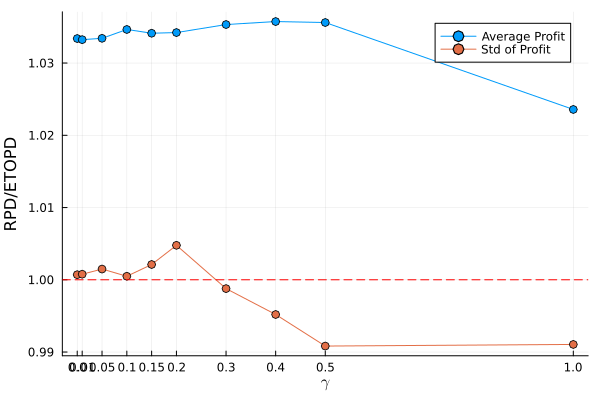

In [20]:
end_index = length(gamma_list)
plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
hline!([1.0], linestyle=:dash, color=:red, label="")
# savefig(string(data_dir, "RPD_vs_ETOPD.pdf"))

##### Boxplot

In [18]:
# Profit_ETO_All_Ins = profit_ETO_avg[:,1];
# Profit_RO_All_Ins = Dict();
# for g_index in 1:length(gamma_list)
#     gamma=gamma_list[g_index]
#     Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO_avg[:,1,g_index]
# end

In [19]:
# gamma_chosen = gamma_list[1:5]
# data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
# labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# # --- 1) 展开成长表 ---
# df = DataFrame(
#     value = vcat(data...),
#     group = repeat(labels, inner = length(data[1]))
# )

# mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色

# # --- 3) 绘制箱线图 ---
# @df df boxplot(:group, :value;
#     group = :group,
#     palette = mycolors,
#     legend = false,
#     ylabel = "Revenue",
#     # title = "Revenue Distribution"
# )

# # --- 4) 计算均值 ---
# means = combine(groupby(df, :group), :value => mean => :mean_val)

# for i in 1:length(labels)
#     scatter!([labels[i]], [means.mean_val[i]];
#         color = :red,
#         marker = (:star, 10),
#         label = "")
# end

# # # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
# plot!(labels, means.mean_val;
#     seriestype = :line,
#     color = :red,
#     lw = 2,
#     ls = :dash,
#     label = "Mean trend"
# )